In [35]:
import os
import json

from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import torch


from bigram_estimator import getWordDict, getNgramDict, pLM
from generate_watermark import load_model, generate
from likelihood_ratio_test import L_Gw

In [3]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-125m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


In [4]:
model, tokenizer, device = load_model(args)

In [5]:
encoded_text = tokenizer("I enjoy walking in the", return_tensors="pt")

#1. step to get the logits of the next token
with torch.inference_mode():
  outputs = model(**encoded_text)

next_token_logits = outputs.logits[0, -1, :]
# print(next_token_logits.shape)
# print(next_token_logits)

# 2. step to convert the logits to probabilities
next_token_probs = torch.softmax(next_token_logits, -1)
print(next_token_probs)

# 3. step to get the top 10
topk_next_tokens= torch.topk(next_token_probs, 10)
print(topk_next_tokens)
#putting it together
print(tokenizer.decode(10000))
print(*[(tokenizer.decode(idx), prob) for idx, prob in zip(topk_next_tokens.indices, topk_next_tokens.values)], sep="\n")


tensor([9.0605e-09, 9.1116e-09, 4.9096e-06,  ..., 9.4954e-09, 9.2500e-09,
        1.0485e-08])
torch.return_types.topk(
values=tensor([0.1664, 0.1650, 0.0545, 0.0437, 0.0253, 0.0232, 0.0210, 0.0160, 0.0129,
        0.0123]),
indices=tensor([14193,  2221,  2933,  1895,  1958,   343,  1692,  6768,  2827,   124]))
 NEXT
(' woods', tensor(0.1664))
(' park', tensor(0.1650))
(' dark', tensor(0.0545))
(' rain', tensor(0.0437))
(' snow', tensor(0.0253))
(' city', tensor(0.0232))
(' middle', tensor(0.0210))
(' parks', tensor(0.0160))
(' streets', tensor(0.0129))
(' back', tensor(0.0123))


In [6]:
with torch.inference_mode():
    outputs = model(**encoded_text)
tensor = torch.softmax(outputs.logits[0, -1, :], -1)
# t.decode(torch.arange(tensor.shape[0]))
# tensor[tokenizer("park", return_tensors="pt")['input_ids'][0]]
# tensor
tokenizer.decode(14193)
tokenizer(' woods', return_tensors='pt', return_attention_mask=False, add_special_tokens=False)

{'input_ids': tensor([[14193]])}

In [7]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("hello")

[('hello', (0, 5))]

In [34]:
times = 1 #1000
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-125m', load_fp16=False, prompt_max_length=200, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


To load whole corpora. Only use when analysing over larger corpora

In [5]:
path_watermarked = '/data/corpora_with_watermark/'
json_file_names = [filename for filename in os.listdir(path_watermarked) if filename.endswith('.json')]
# print(json_file_names)
corpus_with_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_watermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_with_watermark += foo

FileNotFoundError: [Errno 2] No such file or directory: '/data/corpora_with_watermark/'

In [53]:
path_nonwatermarked = '/data/corpora_without_watermark/'
json_file_names = [filename for filename in os.listdir(path_nonwatermarked) if filename.endswith('.json')]
corpus_without_watermark = []
for json_file_name in json_file_names:
    with open(os.path.join(path_nonwatermarked, json_file_name)) as json_file:
        foo = json.load(json_file)
    corpus_without_watermark += foo

In [14]:
word_dict_w = getWordDict(corpus_with_watermark, tokenizer)
n_gram_dict_w = getNgramDict(corpus_with_watermark, tokenizer)

word_dict_nw = getWordDict(corpus_without_watermark, tokenizer)
n_gram_dict_nw = getNgramDict(corpus_without_watermark, tokenizer)

In [13]:
n_gram_dict_nw

defaultdict(int,
            {('</', 's'): 2,
             ('s', '>"'): 1,
             ('>"', 'That'): 1,
             ('That', 'Ġwas'): 1,
             ('Ġwas', 'Ġreally'): 1,
             ('Ġreally', 'Ġcool'): 1,
             ('Ġcool', '"'): 1,
             ('"', 'ĠĠ'): 3,
             ('ĠĠ', 'Ġ"'): 4,
             ('Ġ"', 'Yeah'): 1,
             ('Yeah', 'ĠI'): 1,
             ('ĠI', 'Ġdon'): 1,
             ('Ġdon', "'t"): 2,
             ("'t", 'Ġknow'): 2,
             ('Ġknow', 'Ġanything'): 2,
             ('Ġanything', 'Ġabout'): 2,
             ('Ġabout', 'Ġmusic'): 2,
             ('Ġmusic', 'Ġand'): 1,
             ('Ġand', 'ĠI'): 2,
             ('ĠI', 'Ġwatched'): 1,
             ('Ġwatched', 'Ġthe'): 1,
             ('Ġthe', 'Ġvideo'): 1,
             ('Ġvideo', '"'): 1,
             ('Ġ"', 'I'): 2,
             ('I', 'Ġdon'): 1,
             ('Ġmusic', '"'): 1,
             ('Ġ"', 'So'): 1,
             ('So', 'Ġwhat'): 1,
             ('Ġwhat', 'Ġare'): 1,
           

In [15]:
pHat('Ġgot', 'Ġthe', word_dict_w, n_gram_dict_w)
# pHat('The', 'Ġfact', word_dict_nw, n_gram_dict_nw)

0.2727272727272727

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [33]:
#greenlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode("hello")).to(device))
#int(tokenizer.vocab.values()

# path_nonwatermarked = '/data/corpora_without_watermark/'
# with open(os.path.join(path_nonwatermarked, 'corpus_without_watermark.json')) as json_file:
#    corpus_without_watermark = json.load(json_file)

# word_dict_nw = getWordDict(corpus_without_watermark)
# n_gram_dict_nw = getNgramDict(corpus_without_watermark)


deltaarr = torch.arange(0, 1, 0.1)
# deltaarr
Larr, redsum = L_Gw(deltaarr, 'Ġup', word_dict_nw, watermark_processor, tokenizer, model)
# print(redsum)
# plt.plot(deltaarr, Larr)

word = s, greensum = 37.53287887573242, redsum = 110.14005279541016, sum = 147.6729278564453


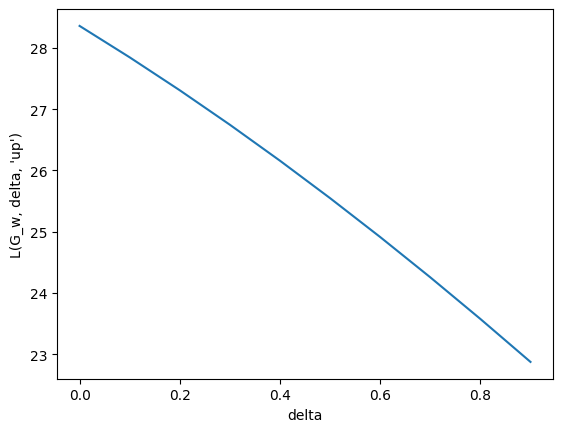

In [31]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

In [45]:
## L gradient descent

optim = torch.optim.SGD()

tensor([[  113,  1711,    21,   269,  3035,   113,  1437,  1437,    22, 14783,
            38,   218,    75,   216,   932,    59,   930,     8,    38,  3996,
             5,   569,   113,  1437,  1437,    22,   100,   218,    75,   216,
           932,    59,   930,   113,  1437,  1437,    22,  2847,    99,    32,
            47,   608,    19,   110,  1730,  1917,  1437,  1437,    22,   100,
           437,  6908,   120,   106,     7,  3836,   113, 50118,   243,    18,
            67,     5,   275,  2214,    11,     5,  1445,  2642,   328,     2]])
